<a href="https://colab.research.google.com/github/beepmo/gator/blob/main/data/06-20/litao3_gating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install impedance -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 968.2 kB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import userdata
import plotly.express as px
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit

In [ ]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/beepmo/gator
%pwd

Cloning into 'gator'...
remote: Enumerating objects: 932, done.
remote: Counting objects: 100% (222/222), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 932 (delta 146), reused 30 (delta 21), pack-reused 710
Receiving objects: 100% (932/932), 49.89 MiB | 8.78 MiB/s, done.
Resolving deltas: 100% (515/515), done.
Updating files: 100% (124/124), done.


'/content'

In [ ]:
%cd "/content/gator/data/07-18/"

/content/gator/data/07-18


# Constant current polarization

A constant current is set to 1µA (measured 0.925-0.95µA). Voltage measured across the sample increases exponentially, from 1.5V to 3.5V.

The mixed conductor model (Maier p445-454) tells us
# stoichiometric polarization
$$
U=IR_{eon}\left( 1-\frac{R_{\text{eon}}}{R_{\text{eon}}+R_{\text{ion}}}\exp\left( -\frac{t}{\tau} \right) \right)
$$
where
$$
\tau=(R_{\text{eon}}+R_{\text{ion}})C^{\delta}.
$$
We will shortly see that the diffusion coefficient $D$ is given by $\tau$,
$$
D^{\delta}=\frac{4L^2}{\pi  ^{2}\tau }.
$$
We have $\log(U(\infty)-U(t))$ linear in $t$ and fit to obtain $\frac{1}{\tau}=3.75\cdot 10^{-4} \mathrm{\frac{1}{s}}$. Lower bounding $L\geq 1\cdot 10^{-3}\text{ m}$, we find
$$
D^{\delta}\geq 1\cdot 10^{-10} \mathrm{\frac{m^{2}}{s}}.
$$
This is huge! Let's bug shoot. The most pertinent bug lies in assuming homogeneous lateral planes when we introduce $L$.

In [ ]:
prep_csv('defbuffer1_0718_141014.csv')

Fill Mode,1



In [ ]:
df = pd.read_csv('defbuffer1_0718_141014.csv')

In [ ]:
df

,Reading,Unit,Range Digits,Disp Digits,Math,Start Group,Limit1 High,Limit1 Low,Limit2 High,Limit2 Low,...,Questionable,Origin,Value,Unit.1,Digits,Output,Sense,Source Limit,Overtemp,Relative Time
0,9.451737e-10,Amp DC,1.000000e-07,5.5,F,F,F,F,F,F,...,F,Main,0.999989,Volt DC,1,T,2W,F,F,0.000000
1,8.738172e-10,Amp DC,1.000000e-08,5.5,F,F,F,F,F,F,...,F,Main,0.993203,Volt DC,1,T,2W,F,F,0.191762
2,9.314973e-10,Amp DC,1.000000e-07,5.5,F,F,F,F,F,F,...,F,Main,0.999990,Volt DC,1,T,2W,F,F,0.600215
3,8.694040e-10,Amp DC,1.000000e-08,5.5,F,F,F,F,F,F,...,F,Main,0.993101,Volt DC,1,T,2W,F,F,0.791953
4,9.314417e-10,Amp DC,1.000000e-07,5.5,F,F,F,F,F,F,...,F,Main,0.999991,Volt DC,1,T,2W,F,F,1.200365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81054,-1.688287e-08,Amp DC,1.000000e-06,5.5,F,F,F,F,F,F,...,F,Main,0.000018,Volt DC,1,F,2W,F,F,10599.808911
81055,-1.721903e-08,Amp DC,1.000000e-06,5.5,F,F,F,F,F,F,...,F,Main,0.000017,Volt DC,1,F,2W,F,F,10601.250726
81056,-1.679807e-08,Amp DC,1.000000e-06,5.5,F,F,F,F,F,F,...,F,Main,0.000020,Volt DC,1,F,2W,F,F,10602.040126
81057,-9.559542e-09,Amp DC,1.000000e-07,5.5,F,F,F,F,F,F,...,F,Main,0.040624,Volt DC,1,F,2W,F,F,10603.171585


In [ ]:
# Time (s)
T = df['Relative Time']

# Current (nA)
I = df['Value'] * 1e9

# Potential (mV)
V = df['Reading'] * 1e3

Text(0.5, 0, 'Time (s)')

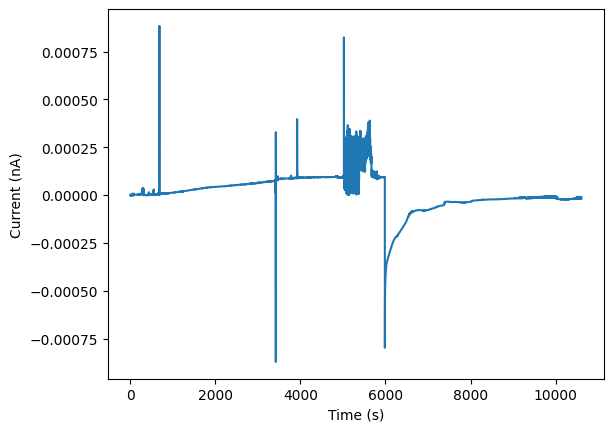

In [ ]:
plt.plot(T, V)
plt.ylabel('Current (nA)')
plt.xlabel('Time (s)')
# plt.xlim(6000)
# plt.ylim(-800,0)

In [ ]:
df_new = df[['Relative Time', 'Value', 'Reading']]
df_new.loc[:, 'Reading'] = df_new['Reading'] * 1e9
df_new.loc[:, 'Value'] = df_new['Value'] * 100
df_new.rename(columns={'Reading': 'Current (nA)', 'Value': 'Vds (1e-2 V)'}, inplace=True)

<ipython-input-38-e44d9732e7c6>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = px.scatter(df, x="Relative Time", y=["Reading"])
fig.show()


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log



Text(0.5, 0, 'Time (s)')

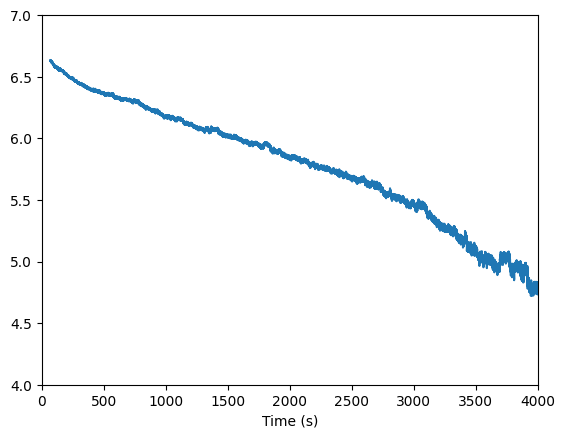

In [ ]:
c1 = 1000
plt.plot(T[c1:],np.log(V[len(T)-1] * np.ones_like(T) - V)[c1:])
plt.xlim(0,4000)
plt.ylim(4,7)
plt.xlabel('Time (s)')

In [ ]:
-1.5/4000

-0.000375